<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Filter-Route-SP---RJ" data-toc-modified-id="Filter-Route-SP---RJ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter Route SP - RJ</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Holyday-Variables" data-toc-modified-id="Holyday-Variables-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Holyday Variables</a></span></li></ul></li><li><span><a href="#Training-and-Out-of-Time-Data" data-toc-modified-id="Training-and-Out-of-Time-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training and Out of Time Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Grouping-Data-into-hourly-bins" data-toc-modified-id="Grouping-Data-into-hourly-bins-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span>Grouping Data into hourly bins</a></span></li></ul></li><li><span><a href="#Montly-analysis" data-toc-modified-id="Montly-analysis-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Montly analysis</a></span></li><li><span><a href="#daily-analysis" data-toc-modified-id="daily-analysis-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>daily analysis</a></span></li><li><span><a href="#Hourly-analisys" data-toc-modified-id="Hourly-analisys-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Hourly analisys</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Moving-Average" data-toc-modified-id="Moving-Average-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Moving Average</a></span></li></ul></li><li><span><a href="#Modeling-One-Hot-Encoding" data-toc-modified-id="Modeling-One-Hot-Encoding-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling One Hot Encoding</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Random Forests</a></span><ul class="toc-item"><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li><li><span><a href="#lightGBM" data-toc-modified-id="lightGBM-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>lightGBM</a></span><ul class="toc-item"><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li></ul></li><li><span><a href="#Modeling-Label-Encoding" data-toc-modified-id="Modeling-Label-Encoding-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Modeling Label Encoding</a></span></li><li><span><a href="#Importance-of-Variables" data-toc-modified-id="Importance-of-Variables-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Importance of Variables</a></span></li></ul></div>

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr, pearsonr
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import preprocessing

from getdata import getdata

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

download_data = False
training = True
seed=42

# Loading Data

In [2]:
# Downloading data from ANAC site
if download_data:
    getdata(period = ('2016-01','2020-06')) # sumarizes all the months in a single file and do initial dataprep / creates the data.csv file


In [3]:
# Loading Data
anac_df = pd.read_csv("ANAC_DATA/data.csv", low_memory=False)

# Getting brazilian holidays
feriados = pd.read_csv("feriados.csv")

In [4]:
# checking data shape
anac_df.shape, feriados.shape

((3604602, 20), (57, 3))

In [5]:
# sample
anac_df.head()

id_basica sg_empresa_icao           ds_tipo_empresa  ds_grupo_di  \
0   12017073             AZU  TRANSPORTE AÉREO REGULAR  NÃO REGULAR   
1   12017127             AZU  TRANSPORTE AÉREO REGULAR  NÃO REGULAR   
2   12017128             AZU  TRANSPORTE AÉREO REGULAR  NÃO REGULAR   
3   12017129             AZU  TRANSPORTE AÉREO REGULAR  NÃO REGULAR   
4   12017130             AZU  TRANSPORTE AÉREO REGULAR  NÃO REGULAR   

  ds_servico_tipo_linha  nr_ano_partida_real hr_partida_real dt_partida_real  \
0            PASSAGEIRO               2016.0        13:26:00      2016-01-01   
1            PASSAGEIRO               2016.0        10:26:00      2016-01-01   
2            PASSAGEIRO               2016.0        23:30:00      2016-01-01   
3            PASSAGEIRO               2016.0        03:09:00      2016-01-01   
4            PASSAGEIRO               2016.0        13:18:00      2016-01-01   

  nm_mes_partida_real  nr_mes_partida_real nm_dia_semana_partida_real  \
0             JANEIRO                  1.0                SEXTA-FEIRA   
1             JANEIRO                  1.0                SEXTA-FEIRA   
2             JANEIRO                  1.0                SEXTA-FEIRA   
3             JANEIRO                  1.0                SEXTA-FEIRA   
4             JANEIRO                  1.0                SEXTA-FEIRA   

   nr_dia_partida_real sg_iata_origem sg_uf_origem nm_municipio_origem  \
0                  1.0            SSA           BA            SALVADOR   
1                  1.0            BPS           BA        PORTO SEGURO   
2                  1.0            CNF           MG             CONFINS   
3                  1.0            MCZ           AL           RIO LARGO   
4                  1.0            IGU           PR       FOZ DO IGUAÇU   

  sg_iata_destino  nr_assentos_ofertados  nr_passag_pagos  km_distancia  \
0             MCZ                     69                0         468.0   
1             VCP                    118               98        1115.0   
2             NAT                    118              106        1800.0   
3             CNF                    118               49        1427.0   
4             CWB                     70               64         533.0   

  nr_horas_voadas  
0            1,37  
1            1,77  
2            2,68  
3            2,23  
4            1,43

In [6]:
# sample
feriados.head()

data  fl_feriado                                       desc_feriado
0  2016-01-01           1      confraternização universal (feriado nacional)
1  2016-02-09           1      (terça-feira ) – Carnaval (ponto facultativo)
2  2016-02-10           1   (quarta-feira ) – Quarta-feira  Cinzas (ponto...
3  2016-03-25           1   (sexta-feira ) – Paixão  Cristo (feriado naci...
4  2016-04-21           1       (quinta-feira) – Tirantes (feriado nacional)

# Filter Route SP - RJ

In [7]:
df_sp = anac_df.query("(sg_iata_origem == 'CGH')|(sg_iata_origem == 'GRU') & (sg_iata_destino == 'GIG'| sg_iata_destino == 'SDU') & nr_passag_pagos !=0")

In [8]:
df_sp.shape

(403589, 20)

# Feature Engineering

## Holyday Variables

In [9]:
# creating variables for 1,2 and 3 days before a holiday

feriados['data_d1'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=1)).date()))
feriados['data_d2'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=2)).date()))
feriados['data_d3'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=3)).date()))

feriados['fl_feriado_d1'] = feriados.fl_feriado
feriados['fl_feriado_d2'] = feriados.fl_feriado
feriados['fl_feriado_d3'] = feriados.fl_feriado

In [10]:
feriados.head()

data  fl_feriado                                       desc_feriado  \
0  2016-01-01           1      confraternização universal (feriado nacional)   
1  2016-02-09           1      (terça-feira ) – Carnaval (ponto facultativo)   
2  2016-02-10           1   (quarta-feira ) – Quarta-feira  Cinzas (ponto...   
3  2016-03-25           1   (sexta-feira ) – Paixão  Cristo (feriado naci...   
4  2016-04-21           1       (quinta-feira) – Tirantes (feriado nacional)   

      data_d1     data_d2     data_d3  fl_feriado_d1  fl_feriado_d2  \
0  2015-12-31  2015-12-30  2015-12-29              1              1   
1  2016-02-08  2016-02-07  2016-02-06              1              1   
2  2016-02-09  2016-02-08  2016-02-07              1              1   
3  2016-03-24  2016-03-23  2016-03-22              1              1   
4  2016-04-20  2016-04-19  2016-04-18              1              1   

   fl_feriado_d3  
0              1  
1              1  
2              1  
3              1  
4              1

In [11]:
# joins with df_sp
df_sp = df_sp.merge(feriados[['data','fl_feriado']], left_on='dt_partida_real', right_on='data', how = 'left')
df_sp = df_sp.merge(feriados[['data_d1','fl_feriado_d1']], left_on='dt_partida_real', right_on='data_d1', how = 'left')
df_sp = df_sp.merge(feriados[['data_d2','fl_feriado_d2']], left_on='dt_partida_real', right_on='data_d2', how = 'left')
df_sp = df_sp.merge(feriados[['data_d3','fl_feriado_d3']], left_on='dt_partida_real', right_on='data_d3', how = 'left')

In [12]:
# filling nulls
df_sp.fillna(0,inplace=True)

In [13]:
# droping variables

keep_list = ["dt_partida_real",
             "id_basica",
             "hr_partida_real",
             "nr_dia_partida_real",
             "nm_dia_semana_partida_real",
             "nm_mes_partida_real",
             "nr_mes_partida_real",
             "fl_feriado",
             "fl_feriado_d1",
             "fl_feriado_d2",
             "fl_feriado_d3",
             "nr_ano_partida_real",
             "nr_assentos_ofertados",
             "nr_passag_pagos"]

df_sp = df_sp[keep_list]

In [14]:
# Changing names

df_sp.columns = ["departure_date",
             "id",
             "hr_departure",
             "departure_day_of_month",
             "departure_day_of_week",
             "departure_month",
             "departure_month_encoded",
             "fl_holiday",
             "fl_holiday_d1",
             "fl_holiday_d2",
             "fl_holiday_d3",
             "year",
             "n_seats_offered",
             "n_passengers"]

pt_eng = {'SEGUNDA-FEIRA': 'mon',
                 'TERÇA-FEIRA': 'tue',
                 'QUARTA-FEIRA': 'wed',
                 'QUINTA-FEIRA': 'thu',
                 'SEXTA-FEIRA': 'fri',
                 'SÁBADO': 'sat',
                 'DOMINGO': 'sun',
                 'JANEIRO' : 'jan',
                 'FEVEREIRO': 'feb',
                 'MARÇO': 'mar',
                 'ABRIL': 'apr',
                 'MAIO': 'may',
                 'JUNHO': 'jun',
                 'JULHO': 'jul',
                 'AGOSTO': 'aug',
                 'SETEMBRO': 'sep',
                 'OUTUBRO': 'oct',
                 'NOVEMBRO': 'nov',
                 'DEZEMBRO': 'dec'}

df_sp.replace(pt_eng, inplace = True)

In [15]:
df_sp.set_index("id",inplace = True)

In [20]:
df_sp.head()

departure_date hr_departure  departure_day_of_month  \
id                                                             
12017134     2016-01-01     11:43:00                     1.0   
12017177     2016-01-01     17:35:00                     1.0   
12017359     2016-01-01     14:27:00                     1.0   
12017434     2016-01-01     19:50:00                     1.0   
12017437     2016-01-01     19:54:00                     1.0   

         departure_day_of_week departure_month  departure_month_encoded  \
id                                                                        
12017134                   fri             jan                      1.0   
12017177                   fri             jan                      1.0   
12017359                   fri             jan                      1.0   
12017434                   fri             jan                      1.0   
12017437                   fri             jan                      1.0   

          fl_holiday  fl_holiday_d1  fl_holiday_d2  fl_holiday_d3    year  \
id                                                                          
12017134         1.0            0.0            0.0            0.0  2016.0   
12017177         1.0            0.0            0.0            0.0  2016.0   
12017359         1.0            0.0            0.0            0.0  2016.0   
12017434         1.0            0.0            0.0            0.0  2016.0   
12017437         1.0            0.0            0.0            0.0  2016.0   

          n_seats_offered  n_passengers  diff  
id                                             
12017134              118            58   -60  
12017177              118            56   -62  
12017359              106            95   -11  
12017434              118            64   -54  
12017437              118            50   -68

In [22]:
def memory_opt(df):
    """ reduces memory usage by downcasting numeric columns"""
    
    m_b = df.memory_usage(deep = True).sum() / 1024**2
    
    ints = df.select_dtypes(include='int').columns.values.tolist()
    floats = df.select_dtypes(include='float').columns.values.tolist()
    
    for i in ints:
        df[i] = pd.to_numeric(df[i],downcast = 'integer')
        
    for i in floats:
        df[i] = pd.to_numeric(df[i],downcast = 'float')
        
    m_a = df.memory_usage(deep = True).sum() / 1024**2
    
    print(f'dataframe memory usage before optimization : {m_b} Mb')
    print(f'dataframe memory usage : {m_a} Mb')

In [23]:
memory_opt(dfff)

dataframe memory usage before optimization : 130.8634376525879 Mb
dataframe memory usage : 120.0864486694336 Mb


In [26]:
dfff.head()

departure_date hr_departure  departure_day_of_month  \
id                                                             
12017134     2016-01-01     11:43:00                     1.0   
12017177     2016-01-01     17:35:00                     1.0   
12017359     2016-01-01     14:27:00                     1.0   
12017434     2016-01-01     19:50:00                     1.0   
12017437     2016-01-01     19:54:00                     1.0   

         departure_day_of_week departure_month  departure_month_encoded  \
id                                                                        
12017134                   fri             jan                      1.0   
12017177                   fri             jan                      1.0   
12017359                   fri             jan                      1.0   
12017434                   fri             jan                      1.0   
12017437                   fri             jan                      1.0   

          fl_holiday  fl_holiday_d1  fl_holiday_d2  fl_holiday_d3    year  \
id                                                                          
12017134         1.0            0.0            0.0            0.0  2016.0   
12017177         1.0            0.0            0.0            0.0  2016.0   
12017359         1.0            0.0            0.0            0.0  2016.0   
12017434         1.0            0.0            0.0            0.0  2016.0   
12017437         1.0            0.0            0.0            0.0  2016.0   

          n_seats_offered  n_passengers  diff  
id                                             
12017134              118            58   -60  
12017177              118            56   -62  
12017359              106            95   -11  
12017434              118            64   -54  
12017437              118            50   -68

In [41]:
[x for x in dfff.departure_day_of_month if x%1 == 0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 1.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 9.0,
 9.0,
 9.0,
 20.0,
 20.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 21.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 22.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 23.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 25.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 27.0,
 28.0,
 28.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 2.0,
 9.0,
 9.0,
 9.0,
 16.0,
 16.0,
 23.0,
 23.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1

In [39]:
x = 1025.008569

int(str(x-int(x)).split('.')[1]),x%1

(856900000007954, 0.00856900000007954)

# Training and Out of Time Data

In [29]:
df_2020 = df_sp.query('year == 2020')
df_oot = df_sp.query('year == 2019')
df_sp = df_sp.query('year < 2019')

# EDA

### Grouping Data into hourly bins

In [19]:
#df_sp_h_grouped = df_sp_hours.groupby(["departure_date",
#                               "departure_year",
#                               "departure_month",
#                               "hr_departure",
#                               "departure_day_of_month",
#                               "departure_day_of_week",
#                               "fl_holiday",
#                               "fl_holiday_d1",
#                               "fl_holiday_d2",
#                               "fl_holiday_d3",
#                               "hr_arrival",
#                               "arrival_day_of_month",
#                               "arrival_day_of_week",
#                               "WeekofYear"]
#).agg(n_passengers=('n_passengers', np.sum),
#      n_seats_offered=('n_seats_offered', np.sum),
#      frequency = ('hr_departure', 'count')).reset_index()
#
#df_sp_grouped.memory_usage(deep = True).sum()/1024**2

## Montly analysis 

In [30]:
df_sp_month = df_sp.copy()

df_sp_grouped_month = df_sp_month.groupby(['year','departure_month_encoded']).agg(n_passengers=('n_passengers', np.sum),n_seats=("n_seats_offered", np.sum))
df_sp_grouped_month['seats_pass_diff'] =  df_sp_grouped_month.n_seats -df_sp_grouped_month.n_passengers

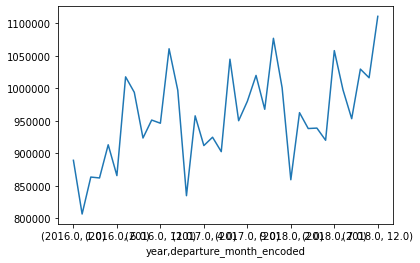

In [31]:
df_sp_grouped_month.n_passengers.plot()

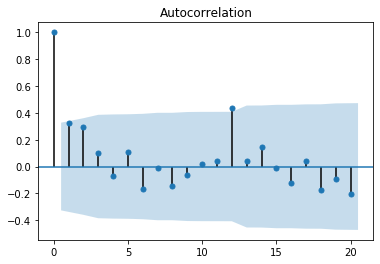

In [33]:
plot_acf(df_sp_grouped_month.seats_pass_diff,lags=20);
plt.show()

invalid value encountered in sqrt


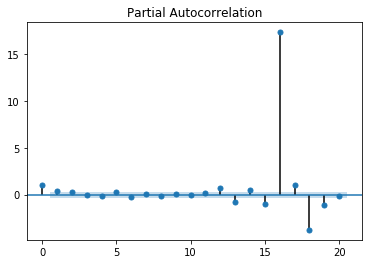

In [34]:
# Ver que porra é essa! invalid value encountered in sqrt

plot_pacf(df_sp_grouped_month.seats_pass_diff,lags=20);
plt.show()

## daily analysis

In [35]:
df_sp_day = df_sp.copy()

df_sp_grouped_day = df_sp_day.groupby(['year','departure_month_encoded','departure_day_of_month']).agg(n_passengers=('n_passengers', np.sum),n_seats=("n_seats_offered", np.sum))
df_sp_grouped_day['seats_pass_diff'] =  df_sp_grouped_day.n_seats -df_sp_grouped_day.n_passengers

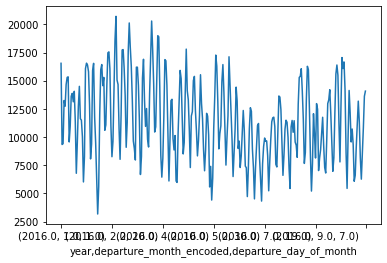

In [36]:
df_sp_grouped_day.seats_pass_diff.head(300).plot()

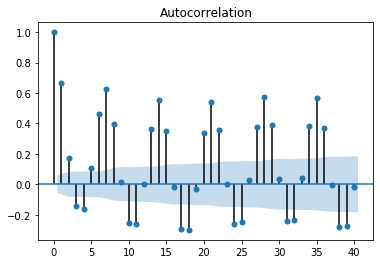

In [37]:
plot_acf(df_sp_grouped_day.seats_pass_diff,lags=40);
plt.show()

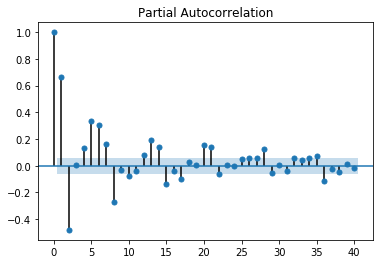

In [38]:
plot_pacf(df_sp_grouped_day.seats_pass_diff,lags=40);
plt.show()

## Hourly analisys

In [39]:
### ADD REINDEX TO FILL INEXISTENT VALUES/ IS THERE A PROBLEM IN HAVING A LOT OF ZEROS?
### CHECK IF THERE ARE ANY DAYS MISSING


df_sp_hour = df_sp.copy()

# tranforming hours variables into bins of one hour interval
df_sp_hour['hr_departure'] = df_sp_hour.hr_departure.apply( lambda x : int(x[:2]))
#df_sp_hours['hr_arrival'] = df_sp_hours.hr_arrival.apply( lambda x : int(x[:2]))
#df_sp_hours['WeekofYear'] = df_sp_hours.departure_date.apply(lambda x : datetime.strptime(str(x),'%Y-%m-%d').isocalendar()[1])

df_sp_grouped_hour = df_sp_hour.groupby(['year','departure_month_encoded','departure_day_of_month','hr_departure']).agg(n_passengers=('n_passengers', np.sum))

In [40]:
df_sp_grouped_hour.head(20)

n_passengers
year   departure_month_encoded departure_day_of_month hr_departure              
2016.0 1.0                     1.0                    5                       78
                                                      6                       80
                                                      7                      651
                                                      8                     1285
                                                      9                      771
                                                      10                    1353
                                                      11                    1173
                                                      12                    1161
                                                      13                    1512
                                                      14                     930
                                                      15                    1557
                                                      16                     729
                                                      17                    1436
                                                      18                    1539
                                                      19                    1016
                                                      20                    1193
                                                      21                    1011
                                                      22                     748
                               2.0                    1                      135
                                                      5                      296

In [60]:
# Creating new index
year = df_sp.year.sort_values().unique()
month= list(range(1,13))
day  = list(range())
hour = list(range(1,25))

fill_index = pd.MultiIndex.from_product([year, month, hour],
                           names=['year','month','day','hour'])


# Filling with reindex
train_new = train.set_index(['Date','Store','Dept']).Weekly_Sales.reindex(fill_index, fill_value = 0)
train_new = train_new.to_frame()
train_new.reset_index(inplace=True)

# merging back with holidays

train_new = train_new.merge(holidays, on='Date', how = 'left')

TypeError: range expected 1 arguments, got 0

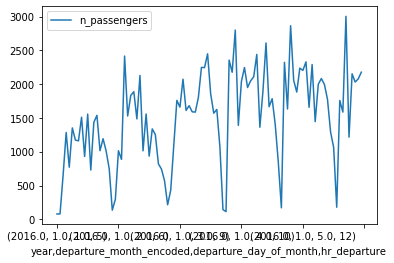

In [41]:
df_sp_grouped_hour.head(100).plot()

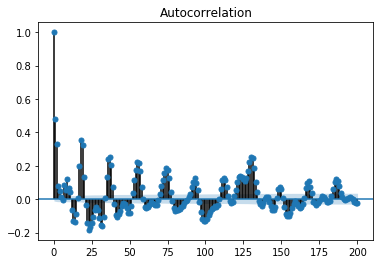

In [42]:
plot_acf(df_sp_grouped_hour,lags=200);
plt.show()

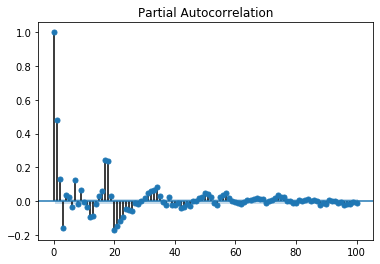

In [43]:
plot_pacf(df_sp_grouped_hour,lags=100);
plt.show()

# EDA

In [100]:
df_sp_grouped.describe().T

count         mean         std     min     25%  \
departure_year          31511.0  2017.563708    1.198802  2016.0  2016.5   
hr_departure            31511.0    13.590746    4.615417     5.0     9.0   
departure_day_of_month  31511.0    15.718574    8.802481     1.0     8.0   
fl_holiday              31511.0     0.038621    0.192694     0.0     0.0   
fl_holiday_d1           31511.0     0.036717    0.188070     0.0     0.0   
fl_holiday_d2           31511.0     0.036717    0.188070     0.0     0.0   
fl_holiday_d3           31511.0     0.036559    0.187679     0.0     0.0   
hr_arrival              31511.0    14.481483    4.601426     0.0    10.0   
arrival_day_of_month    31511.0    15.718670    8.802547     1.0     8.0   
WeekofYear              31511.0    25.683190   15.398482     1.0    12.0   
n_passengers            31511.0   268.351496  172.225630     1.0   127.0   
n_seats_offered         31511.0   376.404525  219.367798     9.0   177.0   
frequency               31511.0     2.513122    1.452499     1.0     1.0   

                           50%     75%     max  
departure_year          2018.0  2019.0  2020.0  
hr_departure              14.0    18.0    23.0  
departure_day_of_month    16.0    23.0    31.0  
fl_holiday                 0.0     0.0     1.0  
fl_holiday_d1              0.0     0.0     1.0  
fl_holiday_d2              0.0     0.0     1.0  
fl_holiday_d3              0.0     0.0     1.0  
hr_arrival                15.0    19.0    23.0  
arrival_day_of_month      16.0    23.0    31.0  
WeekofYear                25.0    39.0    53.0  
n_passengers             234.0   384.0  1141.0  
n_seats_offered          321.0   558.0  1298.0  
frequency                  2.0     4.0     8.0

In [ ]:
# Correlation

df_sp_grouped_day[["n_passengers","n_seats"]].plot.scatter(y="n_passengers",x="n_seats")

In [101]:
df_sp_grouped.head()

departure_date  departure_year departure_month  hr_departure  \
0     2016-01-01            2016             jan             8   
1     2016-01-01            2016             jan             8   
2     2016-01-01            2016             jan             9   
3     2016-01-01            2016             jan            10   
4     2016-01-01            2016             jan            11   

   departure_day_of_month departure_day_of_week  fl_holiday  fl_holiday_d1  \
0                     1.0                   fri         1.0            0.0   
1                     1.0                   fri         1.0            0.0   
2                     1.0                   fri         1.0            0.0   
3                     1.0                   fri         1.0            0.0   
4                     1.0                   fri         1.0            0.0   

   fl_holiday_d2  fl_holiday_d3  hr_arrival  arrival_day_of_month  \
0            0.0            0.0           8                   1.0   
1            0.0            0.0           9                   1.0   
2            0.0            0.0          10                   1.0   
3            0.0            0.0          11                   1.0   
4            0.0            0.0          12                   1.0   

  arrival_day_of_week  WeekofYear  n_passengers  n_seats_offered  frequency  
0                 fri          53            69              138          1  
1                 fri          53           131              288          2  
2                 fri          53           111              426          3  
3                 fri          53           102              603          4  
4                 fri          53           184              453          3

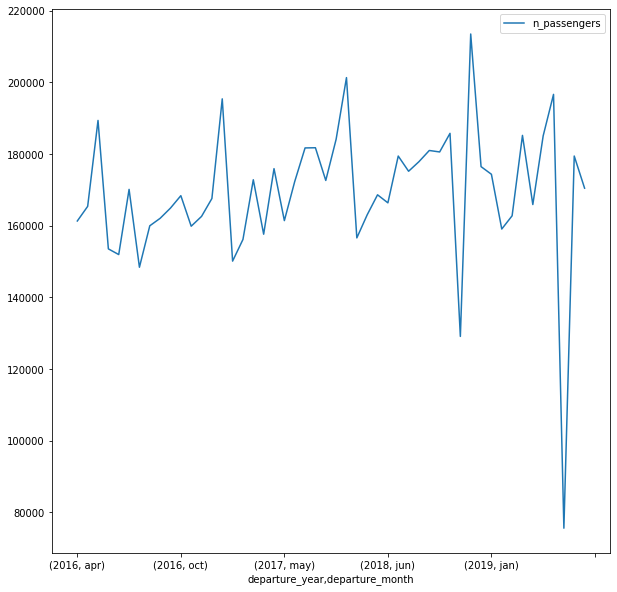

In [116]:
df_sp_grouped.groupby(['departure_year','departure_month']).agg({'n_passengers':'sum'}).plot()

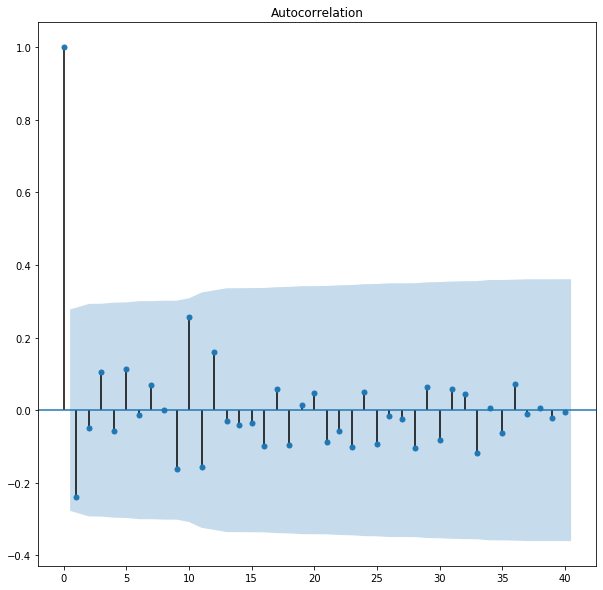

In [114]:
plot_acf(df_sp_grouped.groupby(['departure_year','departure_month']).agg({'n_passengers':'sum'}),lags=40);
plt.show()

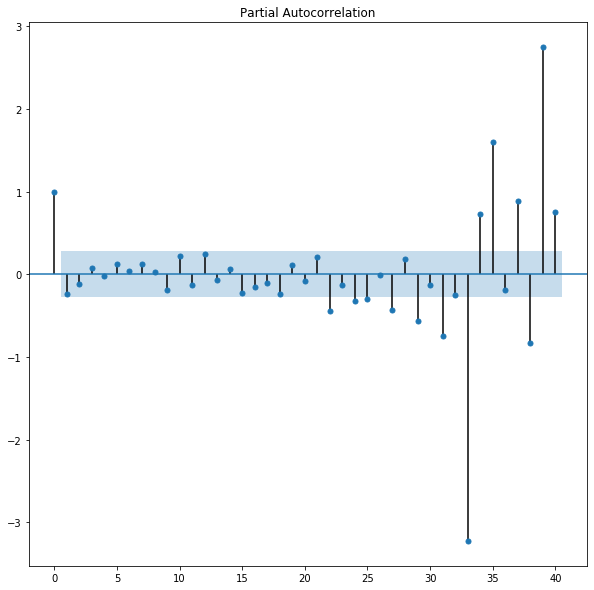

In [115]:
plot_pacf(df_sp_grouped.groupby(['departure_year','departure_month']).agg({'n_passengers':'sum'}),lags=40);
plt.show()

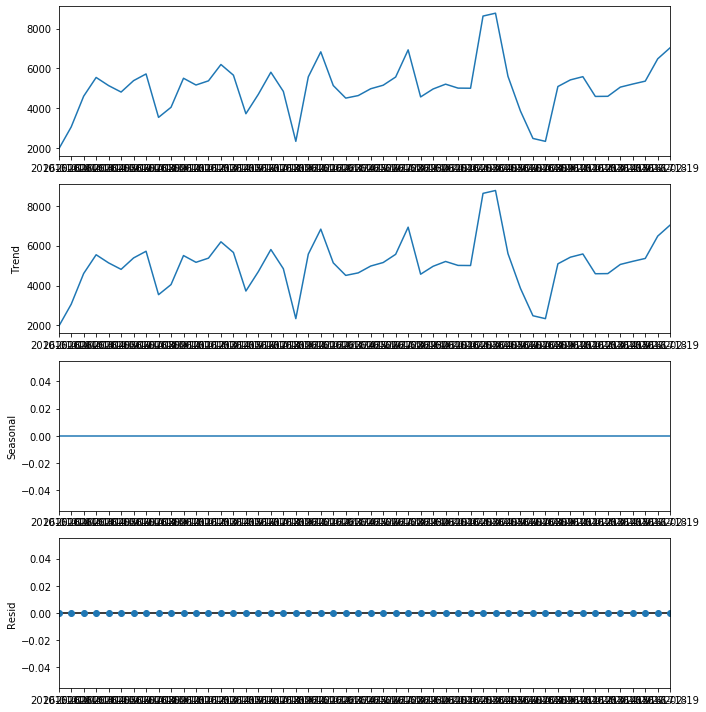

In [68]:
result = seasonal_decompose(df_sp_grouped.groupby('departure_date').agg({'n_passengers':'sum'}).head(50), model='additive', period=1)
result.plot()
plt.show();

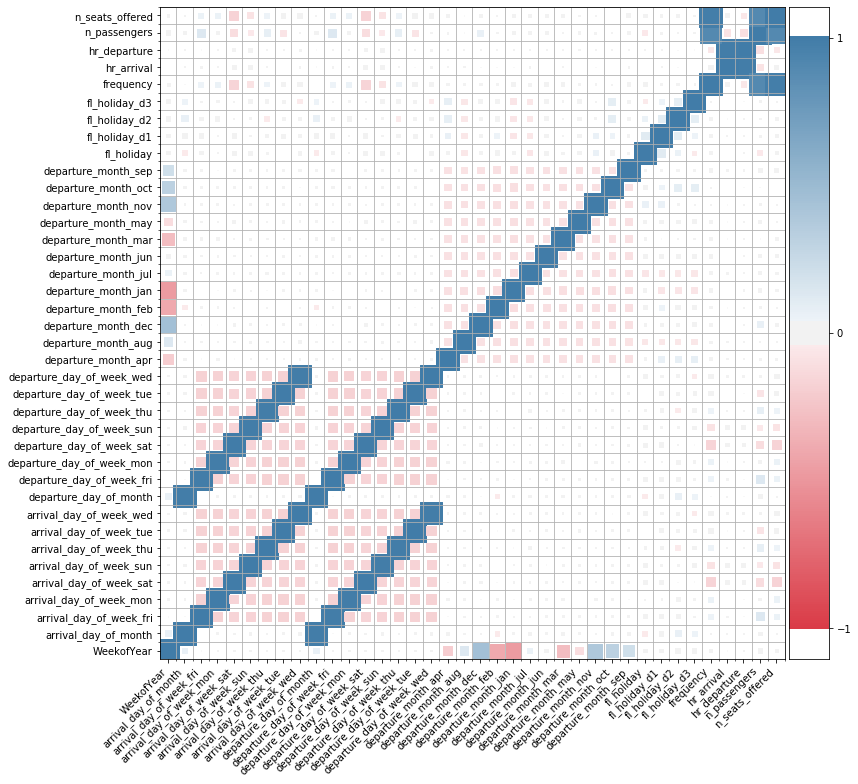

In [31]:
corr_heatmap(df_sp_grouped)

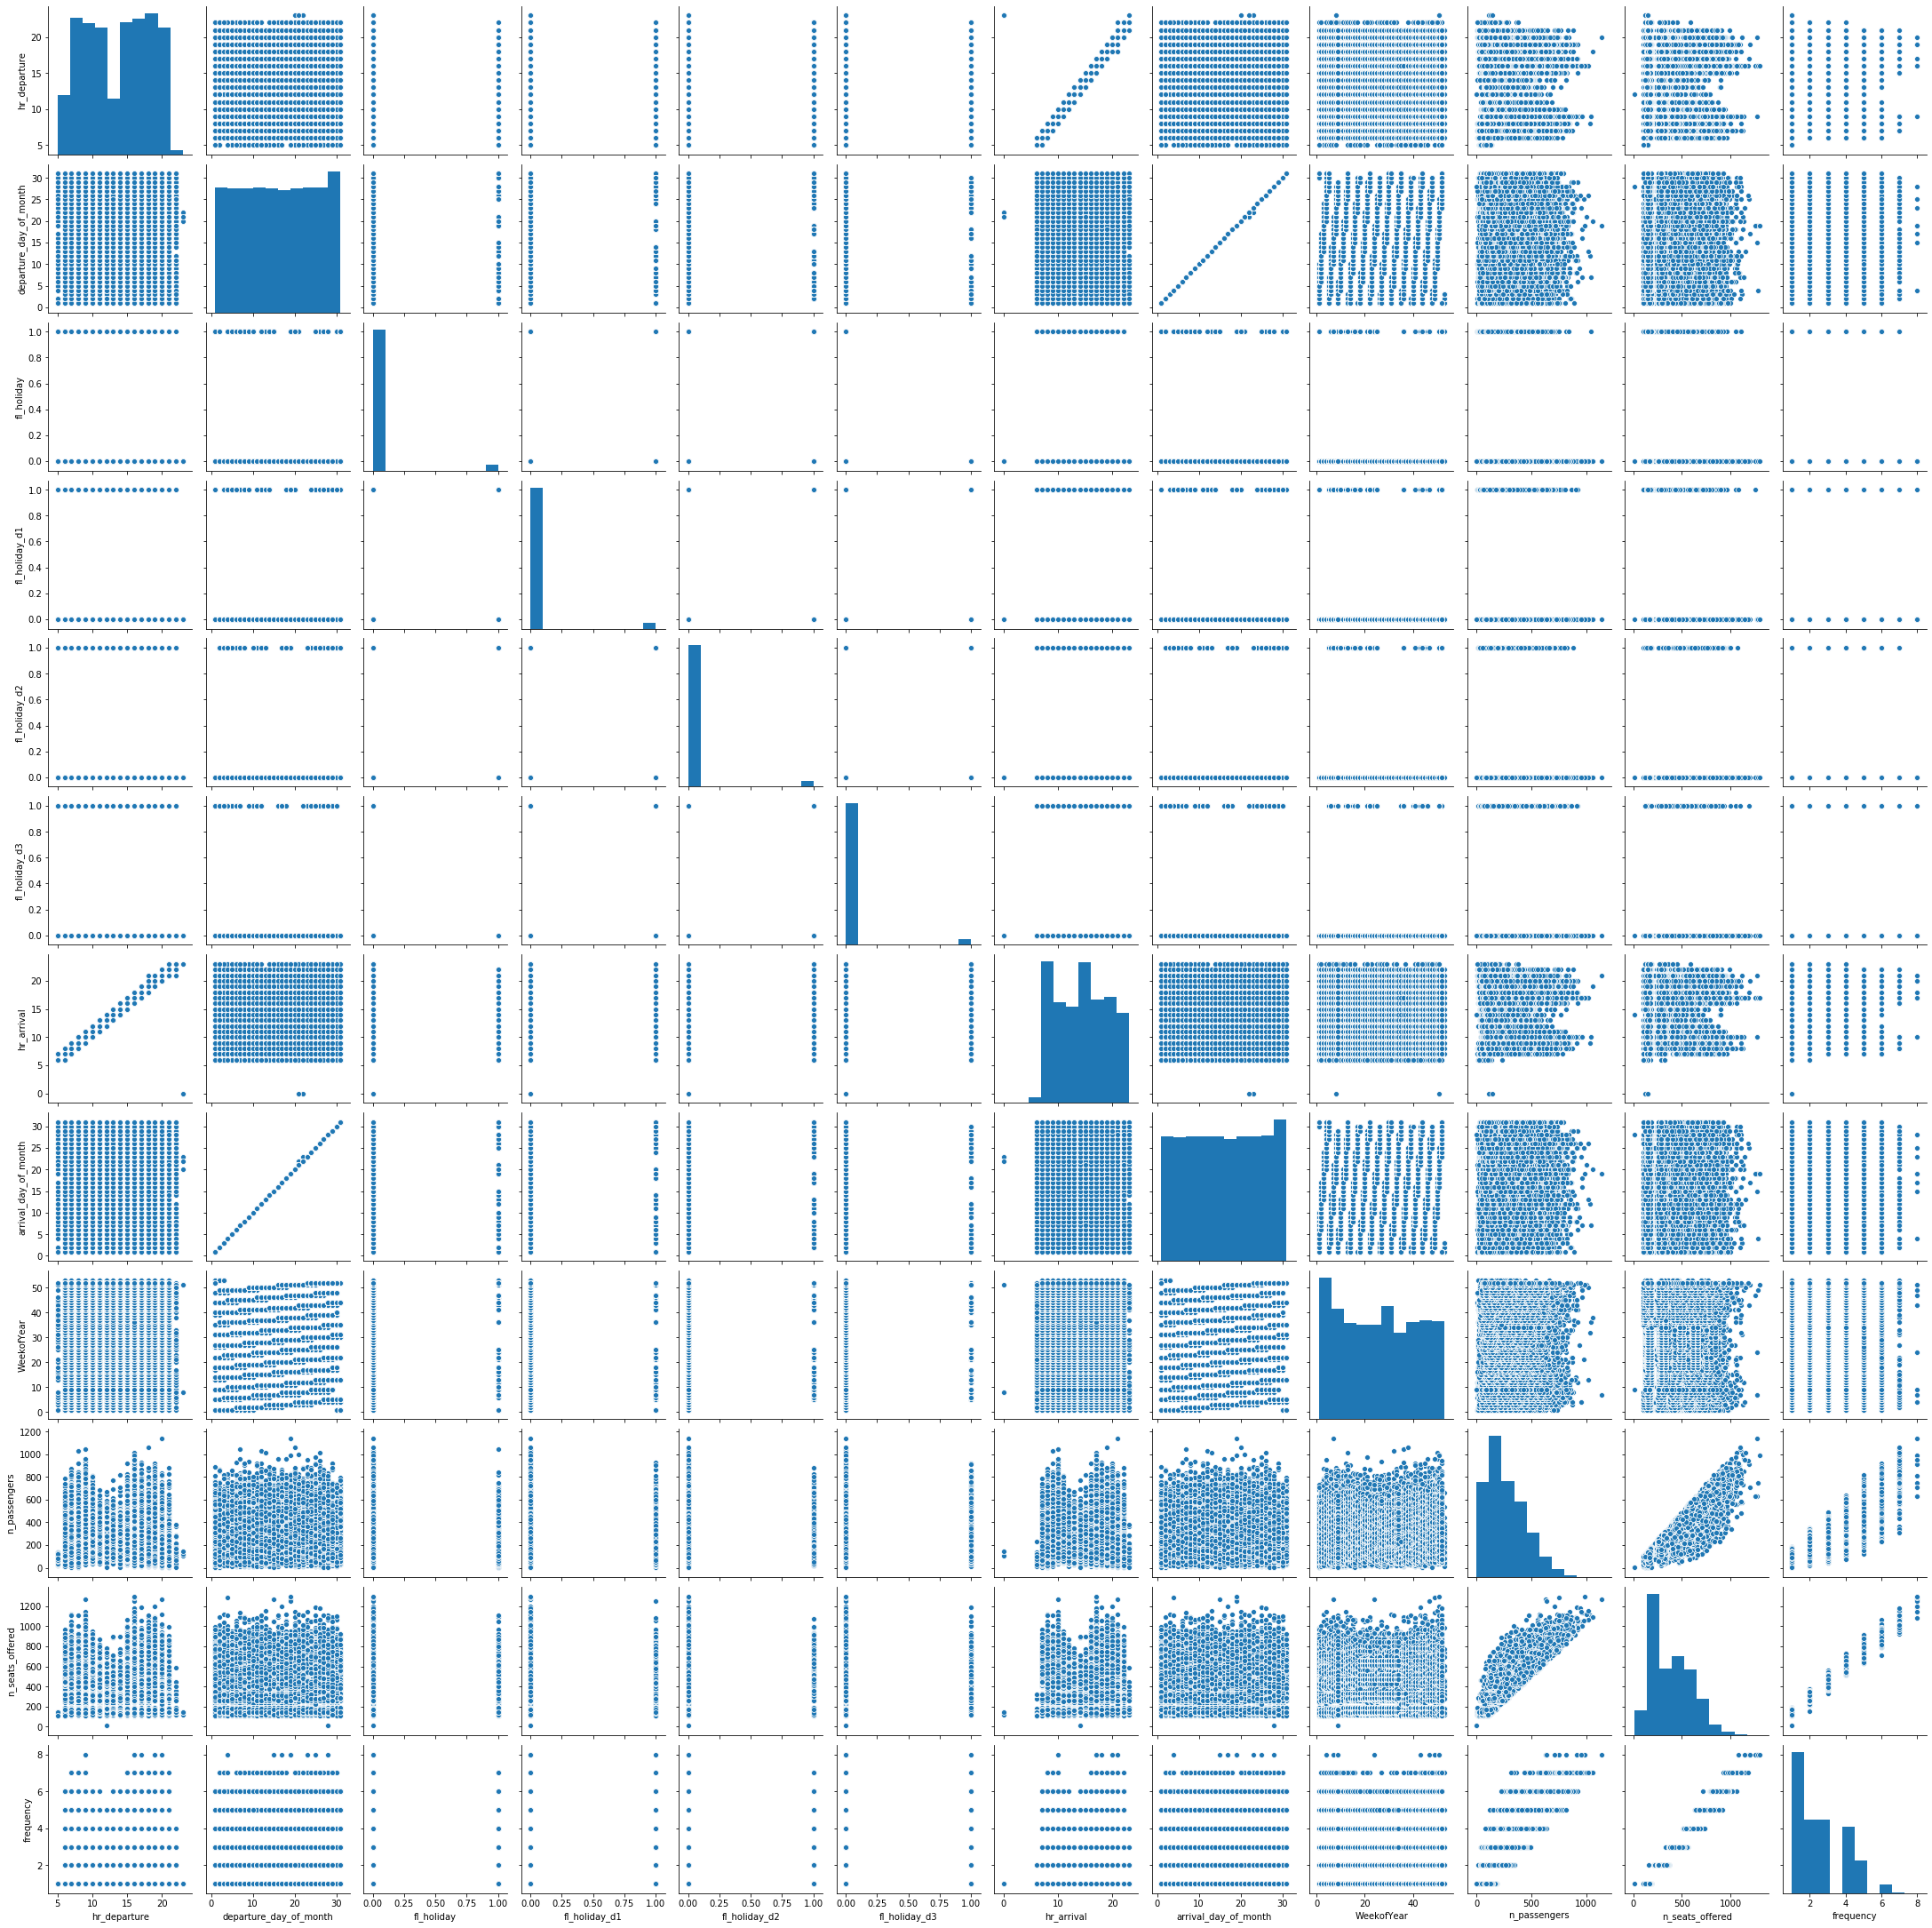

In [29]:
sns.pairplot(df_sp_grouped);

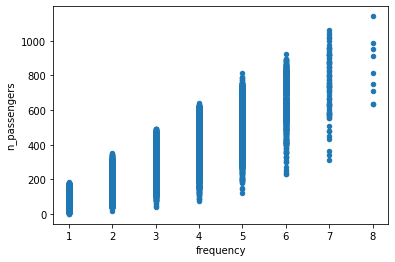

In [56]:
df_sp_grouped.plot.scatter(x = 'frequency',y='n_passengers')

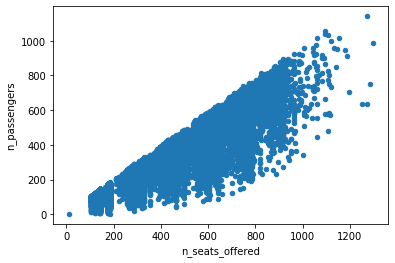

In [57]:
df_sp_grouped.plot.scatter(x = 'n_seats_offered',y='n_passengers')

In [ ]:
df_sp_grouped.plot.scatter(x = 'n_seats_offered',y='f')

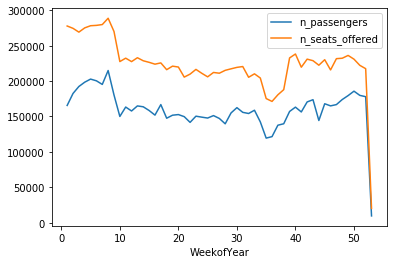

In [24]:
df_sp_grouped.groupby('WeekofYear').agg(n_passengers = ('n_passengers','sum'),
                                        n_seats_offered = ('n_seats_offered','sum')).plot()

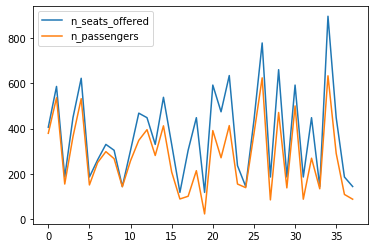

In [25]:
df_sp_grouped.query("'2019-11-09' <= departure_date <= '2019-11-10' ").reset_index()[['n_seats_offered','n_passengers']].plot()

## Moving Average

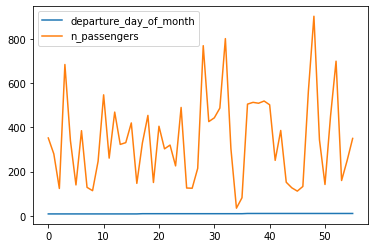

In [26]:
df_sp_grouped.query("'2019-10-09' <= departure_date <= '2019-10-11' ").reset_index()[['departure_day_of_month','n_passengers']].plot()

# Modeling One Hot Encoding

In [30]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
cat_vars = [ 'departure_day_of_week', 'departure_month', 'arrival_day_of_week']
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'one_hot')

In [28]:
df_sp_grouped.head()

departure_date  hr_departure  departure_day_of_month  fl_holiday  \
0     2016-01-01             8                     1.0         1.0   
1     2016-01-01             8                     1.0         1.0   
2     2016-01-01             9                     1.0         1.0   
3     2016-01-01            10                     1.0         1.0   
4     2016-01-01            11                     1.0         1.0   

   fl_holiday_d1  fl_holiday_d2  fl_holiday_d3  hr_arrival  \
0            0.0            0.0            0.0           8   
1            0.0            0.0            0.0           9   
2            0.0            0.0            0.0          10   
3            0.0            0.0            0.0          11   
4            0.0            0.0            0.0          12   

   arrival_day_of_month  WeekofYear  n_passengers  n_seats_offered  frequency  \
0                   1.0          53            69              138          1   
1                   1.0          53           131              288          2   
2                   1.0          53           111              426          3   
3                   1.0          53           102              603          4   
4                   1.0          53           184              453          3   

   departure_day_of_week_fri  departure_day_of_week_mon  \
0                          1                          0   
1                          1                          0   
2                          1                          0   
3                          1                          0   
4                          1                          0   

   departure_day_of_week_sat  departure_day_of_week_sun  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   departure_day_of_week_thu  departure_day_of_week_tue  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   departure_day_of_week_wed  departure_month_apr  departure_month_aug  \
0                          0                    0                    0   
1                          0                    0                    0   
2                          0                    0                    0   
3                          0                    0                    0   
4                          0                    0                    0   

   departure_month_dec  departure_month_feb  departure_month_jan  \
0                    0                    0                    1   
1                    0                    0                    1   
2                    0                    0                    1   
3                    0                    0                    1   
4                    0                    0                    1   

   departure_month_jul  departure_month_jun  departure_month_mar  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   departure_month_may  departure_month_nov  departure_month_oct  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0          

In [29]:
# Out of time set
X_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').drop(['n_passengers'],axis=1)
y_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').n_passengers

# Trains test split
X = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].drop(columns = ['n_passengers','departure_date'])
y = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].n_passengers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [30]:
X.head()

hr_departure  departure_day_of_month  fl_holiday  fl_holiday_d1  \
0             8                     1.0         1.0            0.0   
1             8                     1.0         1.0            0.0   
2             9                     1.0         1.0            0.0   
3            10                     1.0         1.0            0.0   
4            11                     1.0         1.0            0.0   

   fl_holiday_d2  fl_holiday_d3  hr_arrival  arrival_day_of_month  WeekofYear  \
0            0.0            0.0           8                   1.0          53   
1            0.0            0.0           9                   1.0          53   
2            0.0            0.0          10                   1.0          53   
3            0.0            0.0          11                   1.0          53   
4            0.0            0.0          12                   1.0          53   

   n_seats_offered  frequency  departure_day_of_week_fri  \
0              138          1                          1   
1              288          2                          1   
2              426          3                          1   
3              603          4                          1   
4              453          3                          1   

   departure_day_of_week_mon  departure_day_of_week_sat  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   departure_day_of_week_sun  departure_day_of_week_thu  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   departure_day_of_week_tue  departure_day_of_week_wed  departure_month_apr  \
0                          0                          0                    0   
1                          0                          0                    0   
2                          0                          0                    0   
3                          0                          0                    0   
4                          0                          0                    0   

   departure_month_aug  departure_month_dec  departure_month_feb  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   departure_month_jan  departure_month_jul  departure_month_jun  \
0                    1                    0                    0   
1                    1                    0                    0   
2                    1                    0                    0   
3                    1                    0                    0   
4                    1                    0                    0   

   departure_month_mar  departure_month_may  departure_month_nov  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   departure_month_oct  departure_month_sep  arrival_day_of_week_fri  \
0                    0                    0                        1   
1                    0                    0                        1   
2                    0                    0                        1   
3                    0      

## Random Forests

### Random Search

In [28]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
    random_grid = {'bootstrap': [True, False],
                   'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    
    
    random_grid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
    
    # Fit the random search model
    random_grid.fit(X_train, y_train)
    
    print(random_grid.best_params_)
    
    rand_reg = random_grid.best_estimator_.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 101.5min finished


{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


In [121]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,rand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,rand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, rand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, rand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, rand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, rand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,rand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, rand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, rand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

NameError: name 'rand_reg' is not defined

### Grid Search

In [108]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators': [2000],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt'],
                  'max_depth': [5,10,15],
                  'bootstrap': [True]}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


In [109]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 29.16
test MAE: 38.05
train MAPE: 15.32%
test MAPE: 20.74%
train RMSE: 40.30
test RMSE: 53.31
---------------
Out of Time MAE: 46.20
Out of Time MAPE: 39.74%
Out of Time RMSE: 65.27


In [49]:
rf = RandomForestRegressor(n_estimators = 300,
                               min_samples_split =2,
                               min_samples_leaf =1,
                               max_features = 'sqrt',
                               max_depth = 15,
                               bootstrap = True,
                               random_state=seed,
                               n_jobs=-1)
    #neg_root_mean_squared_error
reg_rf = rf.fit(X_train,y_train)


[<matplotlib.lines.Line2D at 0x7fd48b180128>]

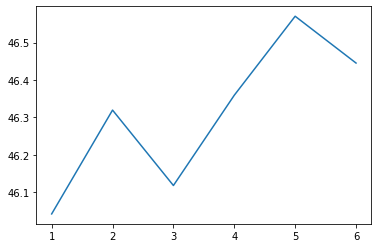

In [48]:
plt.plot(list(range(1,7,1)),MAE)

In [35]:
list(range(100,500,10))

[100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490]

In [50]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_rf.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 29.17
test MAE: 38.04
train MAPE: 15.29%
test MAPE: 20.71%
train RMSE: 40.33
test RMSE: 53.35
---------------
Out of Time MAE: 46.04
Out of Time MAPE: 39.18%
Out of Time RMSE: 65.09


## lightGBM

### Random Search

In [32]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 1, 'reg_alpha': 0, 'num_leaves': 30, 'n_estimators': 4500, 'min_child_samples': 2, 'max_depth': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [33]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 14.37
test MAE: 30.95
train MAPE: 8.38%
test MAPE: 16.30%
train RMSE: 18.99
test RMSE: 44.29
---------------
Out of Time MAE: 46.50
Out of Time MAPE: 33.42%
Out of Time RMSE: 66.98


### Grid Search

In [34]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)

if training:

    param_grid = {
               'max_depth': [30],
               'learning_rate': [0.05],
               'colsample_bytree' : [0.5],
               'num_leaves' : [50],
               'subsample' : [0.25] ,
               'reg_alpha' : [1.2],
               'min_child_samples': [1],
               'n_estimators': [4500]}

    grid = GridSearchCV(lg, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_lgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

#{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.25}

{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 30, 'min_child_samples': 1, 'n_estimators': 4500, 'num_leaves': 50, 'reg_alpha': 1.2, 'subsample': 0.25}


In [35]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_lgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_lgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_lgb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_lgb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_lgb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_lgb.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, reg_lgb.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 9.91
test MAE: 30.94
train MAPE: 5.86%
test MAPE: 16.24%
train RMSE: 12.94
test RMSE: 44.33
---------------
Out of Time MAE: 47.14
Out of Time MAPE: 33.72%
Out of Time RMSE: 67.74


# Modeling Label Encoding

In [59]:
# Encoding days of the week and month variables
#df_sp_grouped.drop(['departure_date'],axis=1,inplace = True)

#cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
cat_vars = [ 'departure_day_of_week', 'departure_month', 'arrival_day_of_week']
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'label')

In [63]:
# Out of time set
X_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').drop(['n_passengers'],axis=1)
y_oot = df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python').n_passengers

# Trains test split
X = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].drop(columns = ['n_passengers','departure_date'])
y = df_sp_grouped[~df_sp_grouped["departure_date"].str.contains('2020-02')].n_passengers


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [61]:
lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)


lgbmrandom_grid = {
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'learning_rate': [0.01,0.05,0.1],
               'colsample_bytree' : [0.3,0.5,1],
               'num_leaves' : [20,30,40,50,60],
               'subsample' : [0.2,0.3,0.5,1] ,
               'reg_alpha' : [0,0.5,1,2],
               'min_child_samples': [1, 2, 4],
               'n_estimators': [1000, 1600, 1800, 2000, 2500, 3000,3500,4000,4500,5000]}


lgbmrandom_grid = RandomizedSearchCV(estimator = lg,
                                     param_distributions = lgbmrandom_grid,
                                     n_iter = 300,
                                     cv = 3,
                                     random_state=seed,
                                     scoring = "neg_mean_absolute_error")

# Fit the random search model
lgbmrandom_grid.fit(X_train, y_train)

print(lgbmrandom_grid.best_params_)

lgbmrand_reg = lgbmrandom_grid.best_estimator_.fit(X_train, y_train)

{'subsample': 0.2, 'reg_alpha': 0, 'num_leaves': 40, 'n_estimators': 2500, 'min_child_samples': 4, 'max_depth': 80, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [64]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,lgbmrand_reg.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,lgbmrand_reg.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, lgbmrand_reg.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, lgbmrand_reg.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, lgbmrand_reg.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, lgbmrand_reg.predict(X_test))**0.5))
print("---------------")
print("Out of Time MAE: {:.2f}".format(mean_absolute_error(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time MAPE: {:.2f}%".format(MAPE(y_oot,lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))))
print("Out of Time RMSE: {:.2f}".format(mean_squared_error(y_oot, lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))**0.5))

train MAE: 18.23
test MAE: 32.40
train MAPE: 10.37%
test MAPE: 17.06%
train RMSE: 24.41
test RMSE: 46.12
---------------
Out of Time MAE: 45.87
Out of Time MAPE: 33.12%
Out of Time RMSE: 67.15


# Importance of Variables

In [ ]:
explainer = shap.TreeExplainer(lgbmrand_reg, approximate = True)

In [ ]:

rf_shap_values = explainer.shap_values(X_test.iloc[0:1000,:])


#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)

In [ ]:
shap.summary_plot(rf_shap_values, X_test.iloc[0:1000,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:])

In [22]:
pd.concat([y_oot.reset_index(drop=True),pd.Series(lgbmrand_reg.predict(X_oot.drop(columns = ['departure_date'])))],axis=1)[100:120].plot()

NameError: name 'y_oot' is not defined

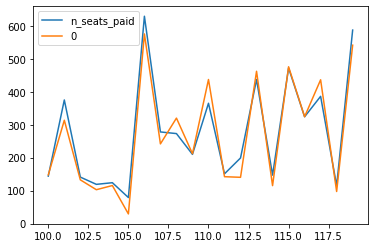

In [66]:
pd.concat([y_test.reset_index(drop=True),pd.Series(lgbmrand_reg.predict(X_test))],axis=1)[100:120].plot()

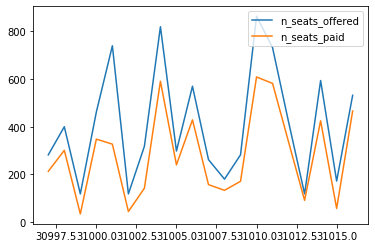

In [21]:
df_sp_grouped.query("departure_date.str.contains('2020-02')", engine='python')[['n_seats_offered','n_passengers']][100:120].plot()